# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Kapildev | Aryal | KapildevAryal, 10/25/2024 | 2.5 Hours | Contribution 25% |
| Member 2: | Pawan  | Bhusal | Pawanbhusal, 10/25/2024| 2.5 Hours | Contribution 25% |
| Member 3: | Manesh | Pandit Chhetri | Maneshpanditchhetri, 10/25/2024 | 2.5 Hours | Contribution 25% |
| Member 4: | Samit | Shrestha | Samitshrestha, 11/08/2024 | 2.5 Hours | Contribution 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

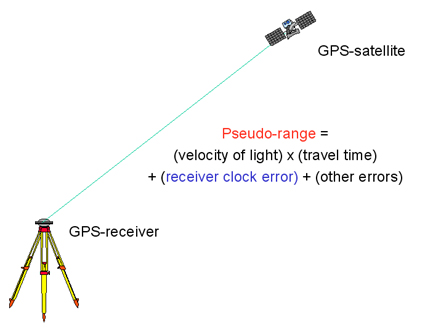

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.



###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_pseudorange = pd.read_excel('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [4]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [5]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [6]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [7]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculate geometric range (predicted pseudoranges) using the Euclidean norm
    geometric_distance = euclidean_norm(r_pos, s_pos)

    # Calculate predicted pseudoranges by adding the clock offset term to the geometric range
    predicted_pseudorange = geometric_distance + cdT

    # Calculate residuals (difference between observed and predicted pseudoranges)
    residuals = pseudorange - predicted_pseudorange

    # Calculate the cost as the sum of squared residuals
    L = np.sum(residuals**2)

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [8]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric distance (Euclidean norm) between receiver and satellites
    geometric_distance = euclidean_norm(r_pos, s_pos)

    # Calculate the predicted pseudorange by adding the clock offset to the geometric distance
    predicted_pseudorange = geometric_distance + cdT

    # Calculate the residuals (difference between observed and predicted pseudoranges)
    residuals = pseudorange - predicted_pseudorange

    # Calculate the difference in position between receiver and satellites, normalized by geometric distance
    delta_r = (r_pos - s_pos) / geometric_distance[:, np.newaxis]

    # Compute gradient with respect to receiver position (x_r, y_r, z_r)
    grad_position = -2 * np.sum(delta_r * residuals[:, np.newaxis], axis=0)

    # Compute gradient with respect to receiver clock offset (cdT)
    grad_cdT = -2 * np.sum(residuals)

    # Combine gradients into a single array
    grad = np.append(grad_position, grad_cdT)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [9]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [10]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# Extract optimized position and clock offset from the result
optimized_position = optimized_params[:3]  # Receiver's position [x_r, y_r, z_r]
optimized_cdT = optimized_params[3]       # Receiver's clock offset [cdT]

# Calculate the final position error (difference between optimized position and ground truth)
final_position_error = optimized_position - GroundTruth

# Capture the number of steps taken for convergence
steps_taken = steps_count

# Get the final cost value from arr_cost (last value)
final_cost = arr_cost[-1] if arr_cost else None

# Get the final gradient values from arr_grad (last value)
final_gradient = arr_grad[-1] if arr_grad else None

optimized_params, final_position_error, steps_taken, final_cost, final_gradient
# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.197094461711757
Final Gradient Values: [ 0.00049101  0.00273591 -0.00840859 -0.00476703]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

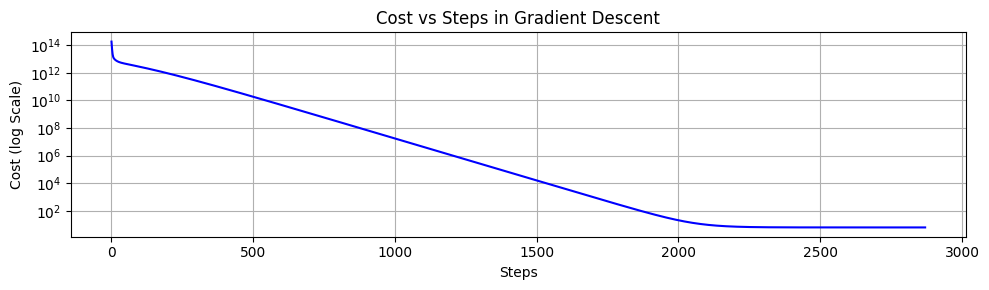

2871


In [11]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot the cost vs steps using semilogy to scale the y-axis (log scale)
ax.semilogy(range(len(arr_cost)), arr_cost, label='Cost vs Steps', color='b')

# Set the x-axis label
ax.set_xlabel("Steps")

# Set the y-axis label (Cost with log scale)
ax.set_ylabel("Cost (log Scale)")

# Set the title of the plot
ax.set_title("Cost vs Steps in Gradient Descent")

# Enable grid for better visualization
ax.grid(True)

# Adjust layout to make sure everything fits well
fig.tight_layout()

# Show the plot
plt.show()

print(len(arr_cost))

# Comment on the pattern:
# Based on the plot, we expect to see a decreasing trend in cost over the iterations (steps).
# The cost should gradually converge to a minimum value as the algorithm progresses.
# A smooth decrease in the cost value indicates the optimization is working correctly.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

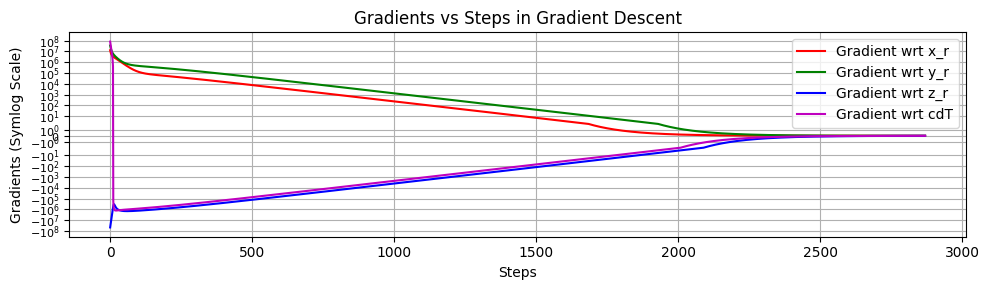

In [12]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

# Convert arr_grad to a numpy array
arr_grad_array = np.array(arr_grad)

# Plot each gradient (x_r, y_r, z_r, cdT) vs steps
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 0], label='Gradient wrt x_r', color='r')
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 1], label='Gradient wrt y_r', color='g')
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 2], label='Gradient wrt z_r', color='b')
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 3], label='Gradient wrt cdT', color='m')

# Set y-axis scale to 'symlog' (symmetric log scale)
ax.set_yscale('symlog')

# Customize tick parameters for y-axis labels
ax.tick_params(axis='y', labelsize=8)

# Set axis labels
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients (Symlog Scale)')

# Set plot title
ax.set_title('Gradients vs Steps in Gradient Descent')

# Add legend
ax.legend()

# Enable grid
ax.grid(True)

# Adjust layout to prevent clipping of labels
fig.tight_layout()

# Show plot
plt.show()

# Comment on the pattern
# All of the gradient components (x_r, y_r, z_r, and cdT) start with relatively high values and decrease over the course of the iterations, as shown in the plot. This pattern suggests that the algorithm is making substantial adjustments early on, gradually refining its estimates.
# As the iterations progress, the gradient values approach zero, indicating that the optimization process is stabilizing. This trend reflects the algorithm's movement toward a solution, where further updates have progressively less impact.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

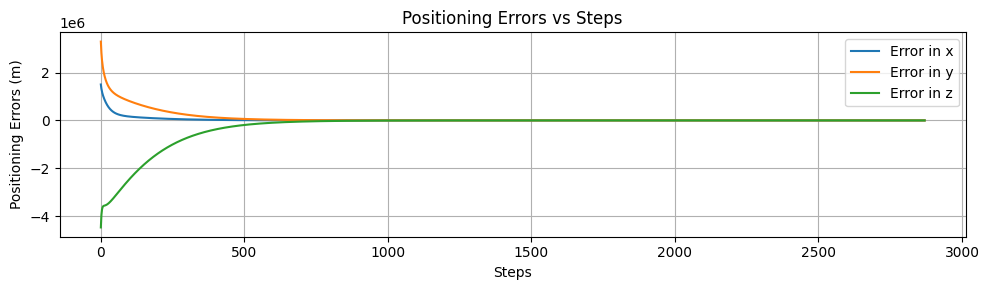

In [13]:
arr_err_np = np.array(arr_err)

# Plot positioning errors vs steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# for x
ax.plot(arr_err_np[:, 0], label='Error in x')
# for y
ax.plot(arr_err_np[:, 1], label='Error in y')
# for z
ax.plot(arr_err_np[:, 2], label='Error in z')

ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors (m)')
ax.set_title('Positioning Errors vs Steps')
ax.legend()

ax.grid(True)
fig.tight_layout()
plt.show()


# Comment on the pattern
# The plot shows a decreasing trend in the positioning errors. Although the initial errors in the x, y, and z components were large, they decrease rapidly as the optimization progresses.
# This indicates that the algorithm effectively reduces positioning inaccuracies over time. Toward the end, the errors converge close to zero, suggesting that the receiver's estimated position is approaching the true value.
# Overall, this confirms that the gradient descent method is effective in reducing positioning errors and providing an accurate estimate by successfully converging to an optimal solution.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [14]:
# set learning rate to 0.01
learning_rate_1 = 0.01
# re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_1)

# print the metrics
print("Optimized Parameters (Learning Rate = 0.01):", optimized_params_2)
print("Final Position Errors of Receiver:", optimized_params_2[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1] if arr_cost else None)
print("Final Gradient Values:", arr_grad[-1] if arr_grad else None)

Converged !
Optimized Parameters (Learning Rate = 0.01): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.197094461711757
Final Gradient Values: [ 0.00049101  0.00273591 -0.00840859 -0.00476703]


In [15]:
# set learning rate to 0.001
learning_rate_2 = 0.001
# re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_2)

# print the metrics
print("Optimized Parameters (Learning Rate = 0.001):", optimized_params_3)
print("Final Position Errors of Receiver:", optimized_params_3[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1] if arr_cost else None)
print("Final Gradient Values:", arr_grad[-1] if arr_grad else None)

Converged !
Optimized Parameters (Learning Rate = 0.001): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45048680e+00]
Final Position Errors of Receiver: [-3.0626223  -2.34752101  3.77518774]
Number of Steps Taken for Convergence: 27145
Final Cost Value: 6.197742857487326
Final Gradient Values: [ 0.00154868  0.00862914 -0.02652096 -0.01503548]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

 Q1 Answer. Increasing the learning rate from 0.001 to 0.01 significantly reduced the number of steps needed for convergence (from 27,145 to 2,871), allowing the algorithm to reach the solution faster without compromising accuracy. Both learning rates achieved similar final parameters, position errors, cost values, and gradients, indicating effective convergence in each case. The higher rate of 0.01 provided a good balance for faster convergence, though a rate set too high might risk overshooting the minimum.

 Q2 Answer. Least Squares Estimation (LSE) and Gradient Descent are both optimization methods, but they differ in their approach and usage:

LSE is a mathematical method that directly minimizes the sum of the squared errors to find an optimal solution. It’s a closed-form solution, which means it calculates the optimal values in one step if an explicit formula is available. LSE is commonly used when a straightforward equation can express the relationship between variables. However, in cases where the problem is complex or involves non-linear relationships, LSE might not be applicable or efficient.

Gradient Descent, on the other hand, is an iterative optimization algorithm that moves step-by-step in the direction that reduces the cost function (in this case, the sum of squared errors). It’s especially useful for large, complex, or non-linear problems where a closed-form solution may not exist. The gradient descent method continues to adjust the parameters until it converges to a minimum cost, as observed here, where the algorithm iteratively reduced the positioning errors until they were minimal.

In summary, LSE provides an exact solution for simpler problems, while Gradient Descent is more flexible and can be applied to complex problems, as shown in these results where Gradient Descent successfully minimized the errors over many iterations.

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [17]:
!pip install ucimlrepo

In [18]:
from ucimlrepo import fetch_ucirepo
from scipy.io import arff

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
data, meta = arff. loadarff ('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/Training Dataset.arff')
df = pd. DataFrame(data)

# TO DO: display sizes of X and Y (1 mark)
X = df.drop(columns='Result')
print('Size of X(feature matrix):', X.shape)

y = df['Result']
print('Size of y(target vector):',y.shape)


Size of X(feature matrix): (11055, 30)
Size of y(target vector): (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution:
 Result
b'1'     6157
b'-1'    4898
Name: count, dtype: int64


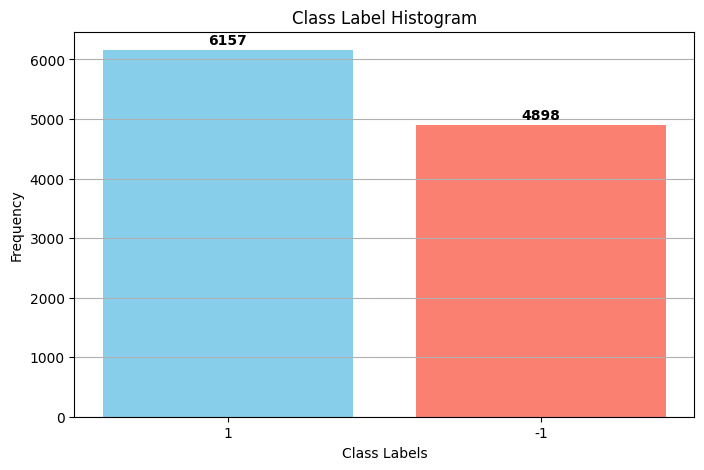

In [19]:
# TO DO: Check the class distribution of y (2 mark)
class_distribution = y.value_counts()
print("Class distribution:\n", class_distribution)

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.bar(class_distribution.index, class_distribution.values, color=['skyblue', 'salmon'])

# Display exact values for each bin in the histogram
for i, value in enumerate(class_distribution.values):
    plt.text(i, value + 50, str(value), ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Label Histogram')
plt.xticks(class_distribution.index)
plt.grid(axis='y')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [20]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)
# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small :", X_small.shape)
print("Size of y_small :", y_small.shape)

Size of X_small : (331, 30)
Size of y_small : (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [21]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import pandas as pd

# Function to train and evaluate the model
def evaluate_model(X, y):
   # Convert byte-string labels to integers
    y = y.apply(lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else x)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Instantiate the model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    y_test_prob = model.predict_proba(X_test)  # For log loss
    log_loss_value = log_loss(y_test, y_test_prob)

    return (
        X.shape[0],  # data_size
        X_train.shape[0],  # training_samples
        X_test.shape[0],  # testing_samples
        training_accuracy,  # training_accuracy
        testing_accuracy,  # testing_accuracy
        log_loss_value  # log_loss
    )

# Implement Machine Learning Model
results = []

# Using full dataset (X, y)
results.append(evaluate_model(X, y))

# Using first two columns of X and y
results.append(evaluate_model(X.iloc[:, :2], y))

# Using smaller dataset (X_small, y_small)
results.append(evaluate_model(X_small, y_small))

# Create results DataFrame
results_df = pd.DataFrame(results, columns=["data_size", "training_samples", "testing_samples", "training_accuracy", "testing_accuracy", "log_loss"])
results_df.index = ["Full Dataset", "First Two Columns", "Small Dataset"]

# Print results
print(results_df)



                   data_size  training_samples  testing_samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Small Dataset            331               231              100   

                   training_accuracy  testing_accuracy  log_loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Small Dataset               0.943723          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [22]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

# Convert byte-string labels to integers
y = y.apply(lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else x)
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate and train the model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Print the dimensions of the target vector and predicted output
print("Dimension of actual target values:", y_test.shape)
print("Dimension of predicted output:", y_test_pred.shape)

Dimension of actual target values: (3317,)
Dimension of predicted output: (3317,)


Confusion Matrix:
[[1341  157]
 [  99 1720]]


Text(113.9222222222222, 0.5, 'true value')

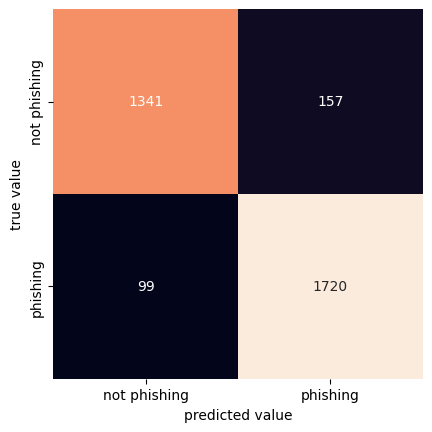

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_test_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [24]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Calculate classification report
class_report = classification_report(y_test, y_test_pred)

# Print classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1. Is the dataset imbalanced? Does it affect model performance?

Answer:

Yes, the dataset is imbalanced. When we checked the class distribution, we saw that there are significantly more instances of one class (legitimate websites or phishing websites) than the other. This imbalance can affect model performance by biasing the model towards predicting the majority class, making it less sensitive to the minority class. As a result, the model might struggle to detect phishing websites if they represent the minority, leading to a higher rate of false negatives.

2. Does the model overfit or underfit for each of the 3 cases?

Answer:

Full Dataset: With a training accuracy of 93.2% and testing accuracy of 92.3%, the model shows minimal overfitting, indicating it generalizes well on unseen data.

First Two Columns Only: The training and testing accuracies are 56.3% and 55.7%, respectively. This is a case of underfitting. The low accuracy shows that the model doesn’t have enough information from just two features, making it unable to capture patterns in the data effectively.

Small Dataset (3%): The training accuracy is 94.4%, and testing accuracy is 91.0%. The slight drop from training to testing accuracy suggests minor overfitting, which is expected with a smaller dataset. The model performs well on the training data but doesn’t generalize as well to new data due to the limited data size.

3. How do the training and testing accuracy change depending on the amount of data used?

Answer:

Full Dataset: The training accuracy is 93.2%, and testing accuracy is 92.3%, showing that with a larger data size, the model performs consistently on both sets, achieving high accuracy and demonstrating good generalization.

First Two Columns Only: With only two features, training accuracy drops to 56.3% and testing accuracy to 55.7%. This significant decrease indicates that the model lacks the information needed for accurate predictions, resulting in underfitting.

Small Dataset: The training accuracy is 94.4%, while testing accuracy is slightly lower at 91.0%. The model fits well on the limited training data but struggles more to generalize on new data due to overfitting with the small sample size.

4. What do a false positive and a false negative represent? Which one is worse?

Answer:

False Positive: This would mean predicting a legitimate website as a phishing site, which could result in unnecessary caution or blocked access to safe websites.

False Negative: This would mean predicting a phishing website as legitimate, which could pose security risks to users by exposing them to phishing attacks.

In this scenario, a false negative is worse because it fails to protect users from phishing threats, potentially leading to compromised security. The consequences of false negatives are typically more severe than false positives in this context.

5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this?

Answer:

Given that false negatives are more dangerous, we would want to maximize recall. This would ensure that we catch as many phishing websites as possible, even if it means occasionally marking a legitimate website as phishing that is accepting some false positives.

To increase recall, we could:

Adjust the decision threshold to favor the phishing class more.
Use techniques like class weighting in LogisticRegression to assign a higher penalty for false negatives.
Use sampling techniques like oversampling the minority class (phishing) or undersampling the majority class.

6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences?

Answer:

Full Dataset: Log Loss is 0.19, which is relatively low, indicating high confidence in the model’s predictions. The large dataset size allows the model to make well-calibrated predictions, reducing uncertainty.

First Two Columns Only: Log Loss is higher at 0.68, reflecting the model’s reduced confidence. This higher Log Loss stems from underfitting, as the limited feature set doesn’t provide enough information for accurate probability estimates, resulting in less reliable predictions.

Small Dataset (3%): Log Loss is 0.20, which is similar to the full dataset but slightly higher. This increase suggests that, while the model performs adequately, it’s less confident due to the limited training data, which leads to slight overfitting and reduced reliability in probability predictions.

In summary, these Log Loss differences arise due to changes in the feature set and data volume.

